# Урок 3. Логистическая регрессия. Log Loss

1. Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.  
2. Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.
3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).
4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).
5. Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.
6. Могла ли модель переобучиться? Почему?
7. Создайте функции eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций соответственно.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Данные и функции из урока:

In [2]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450,
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

In [3]:
def calc_std_feat(x):
    res = (x - x.mean()) / x.std()
    return res

### Задание 1. Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.

In [7]:
# ограничим возможные значения для y_pred
def calc_logloss(y, y_pred):
    const = 1e-8 # любые значени меньше константы - заменяются этой константой
                  # также ставим и верхнюю границу, чтобы правильно считать log_loss, если у нас правдив нулевой класс
    y_pred = pd.Series(y_pred)
    y_pred[y_pred < const] = const
    y_pred[y_pred > 1 - const] = 1 - const
    y_pred = np.array(y_pred)
    
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [5]:
# сигмоидная функция, превращает значения скалярного произведения весов на признаки
# в вероятность, что вектор значений принадлежит классу 1
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

In [6]:
# нормализуем третий признак
X_norm = X.copy()
X_norm = X_norm.astype(np.float64)
X_norm[2] = (X[2] - X[2].min()) / (X[2].max() - X[2].min())
X_norm

array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  2.        ,  1.        ,  3.        ,
         0.        ,  5.        , 10.        ,  1.        ,  2.        ],
       [ 0.03225806,  0.16129032,  0.19354839,  0.09677419,  0.64516129,
         0.22580645,  0.67741935,  1.        ,  0.        ,  0.35483871],
       [ 1.        ,  1.        ,  2.        ,  1.        ,  2.        ,
         1.        ,  3.        ,  3.        ,  1.        ,  2.        ]])

In [8]:
# алгоритм логистической регрессии
def eval_model(X, y, iterations, alpha=1e-4, metric: callable = None):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    
    metric_log = []
    w_log = []
    
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = metric(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T))
        metric_log.append(err)
        w_log.append(W.copy())
        
        if i % (iterations / 10) == 0:
            print(i, W, err)
        
    return W, metric_log, w_log

### Задание 2. Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.

#### Запускаем модель на 5000 итераций с альфа = 0.5

In [75]:
W, metric_log, w_log = eval_model(X_norm, y, iterations=5000, alpha=5e-1, metric=calc_logloss)

500 [-5.34156524 -1.1824711  -0.85359765  5.32461079] 0.33204502517273343
1000 [-6.68415537 -1.33381015 -2.86703783  6.88644498] 0.29830179219427333
1500 [-7.62149842 -1.42306624 -4.59906445  8.0440988 ] 0.2773336019491912
2000 [-8.44928978 -1.5074029  -6.08016924  9.07147413] 0.26154293404761586
2500 [-9.22280294 -1.59272    -7.38437654 10.02673941] 0.24865412275970428
3000 [-9.95571403 -1.67788479 -8.56399554 10.9271837 ] 0.23765986496483116
3500 [-10.65325777  -1.76155202  -9.65100215  11.78055726] 0.22804124554506533
4000 [-11.31871459  -1.84295236 -10.66488034  12.59186234] 0.21949500898328603
4500 [-11.95473637  -1.92174576 -11.61809843  13.36500299] 0.21182364844031598
5000 [-12.56363602  -1.99783406 -12.51919554  14.10326271] 0.204887035740202


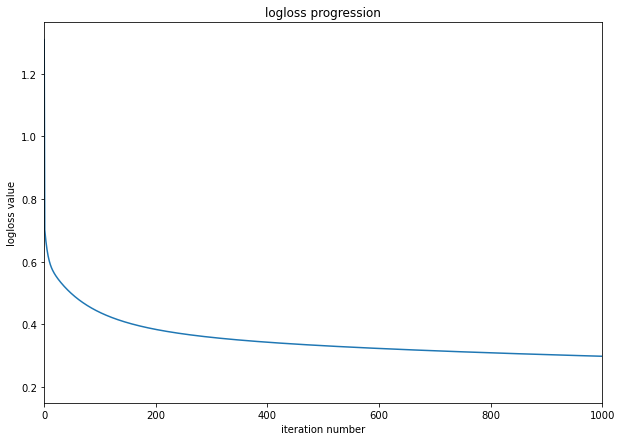

In [10]:
fig = plt.figure(figsize=(10, 7))
plt.plot(range(len(metric_log)), metric_log)
plt.xlim(0, 1000)

plt.title('logloss progression')
plt.xlabel('iteration number')
plt.ylabel('logloss value')

plt.show()

Видим, что значение нашей функции потерь постоянно уменьшается и не собирается останавливаться
  
Примерно на 200 итерации logloss = 0.4, а около 1000 итерации уже 0.3  
  
При увеличении альфы, можно получить еще более низкие параметры logloss функции. Пробуем)))

In [32]:
W, metric_log2, w_log2 = eval_model(X_norm, y, iterations=5000, alpha=5, metric=calc_logloss)

500 [-21.44767829  -3.45450999 -22.36582756  24.64542033] 0.1456806266433144
1000 [-23.86370986  -3.5710502  -28.00046913  27.52075462] 0.12542648283500032
1500 [-26.2458892   -3.75063669 -31.40827245  30.34198799] 0.1140782299581933
2000 [-28.35170266  -4.01801626 -34.21251794  32.79701093] 0.10670480290948647
2500 [-30.21340493  -4.25266226 -36.68472305  34.95992144] 0.10097221338966447
3000 [-31.8904961   -4.46184563 -38.91301054  36.90243301] 0.09632924802170609
3500 [-33.42382052  -4.65090245 -40.95433368  38.67360376] 0.09244970308375153
4000 [-34.84214651  -4.82362444 -42.84816525  40.30786649] 0.08912798067791447
4500 [-36.1664514   -4.98279945 -44.62289847  41.83026314] 0.08622785694323351
5000 [-37.4124769   -5.13053979 -46.29956955  43.25955077] 0.08365534247489162


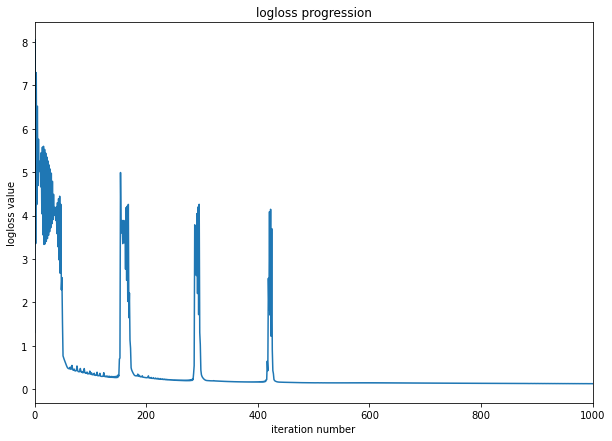

In [30]:
fig = plt.figure(figsize=(10, 7))
plt.plot(range(len(metric_log2)), metric_log2)
plt.xlim(0, 1000)

plt.title('logloss progression')
plt.xlabel('iteration number')
plt.ylabel('logloss value')

plt.show()

Модель подобрала такие веса, что logloss = 0.0811  
  
Практического смысла это конечно же не имеет, так как это переобученная модель, которая на тестовых значениях скорее всего выдаст огромную ошибку  

### Задание 3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).

In [11]:
def calc_pred_proba(W, X):
    z = np.dot(W, X)
    y_pred_proba = sigmoid(z)
    return y_pred_proba

In [12]:
y_pred_proba = calc_pred_proba(W, X_norm)

In [13]:
y_proba_comparison = pd.DataFrame({'True y': y, 'Predicted y': y_pred_proba})
y_proba_comparison['Diff'] = y_proba_comparison['True y'] - y_proba_comparison['Predicted y']
y_proba_comparison

,True y,Predicted y,Diff
0,0.0,0.296911,-0.296911
1,0.0,0.077455,-0.077455
2,1.0,0.999901,0.000099
3,0.0,0.158459,-0.158459
4,1.0,0.828138,0.171862
5,0.0,0.216312,-0.216312
6,1.0,0.999987,0.000013
7,0.0,0.060009,-0.060009
8,1.0,0.387411,0.612589
9,1.0,0.999258,0.000742


Таблица сверху сравнивает истинные и предсказанные значения классов

У модели, предсказавшей значения сверху logloss = 0.19411. Странновато, что есть такая большая погрешность в предсказании 8-го значения  
  
Я уверен, что модель переобучена, могла бы и восьмое значение предсказать точно))

### Задание 4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).

In [14]:
def calc_pred(W, X):
    y_pred_proba = calc_pred_proba(W, X)
    
    # проверяем, больше-равно или меньше значение чем 0.5, получаем True/False, применяем к каждому значению int()
    y_pred = list(map(int, y_pred_proba >= .5))
    return y_pred

In [15]:
y_pred = calc_pred(W, X_norm)
y_pred = np.array(y_pred)

In [16]:
y_comparison = pd.DataFrame({'True y': y, 'Predicted y': y_pred})
y_comparison['Diff'] = y_comparison['True y'] - y_comparison['Predicted y']
y_comparison

,True y,Predicted y,Diff
0,0.0,0,0.0
1,0.0,0,0.0
2,1.0,1,0.0
3,0.0,0,0.0
4,1.0,1,0.0
5,0.0,0,0.0
6,1.0,1,0.0
7,0.0,0,0.0
8,1.0,0,1.0
9,1.0,1,0.0


Модель правильно определила класс у 9 из 10 обьектов

### Задание 5. Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.

$$accuracy = \frac{1}{n} \sum^{n}_{i=1}[y\_pred_{i}=y_{i}]$$

In [17]:
def accuracy(y, y_pred):
    accuracy = sum(list(map(int, y == y_pred))) / len(y)
    return accuracy

In [18]:
accuracy = accuracy(y, calc_pred(W, X_norm))
accuracy

0.9

In [19]:
def confusion_matrix(y, y_pred):
    tp = np.array(list(map(int, (y == 1)*(y_pred == 1)))).sum()
    fp = np.array(list(map(int, (y == 0)*(y_pred == 1)))).sum()
    fn = np.array(list(map(int, (y == 1)*(y_pred == 0)))).sum()
    tn = np.array(list(map(int, (y == 0)*(y_pred == 0)))).sum()
    conf_matrix = pd.DataFrame({'y=1': [tp, fn], 
                                'y=0': [fp, tn]},
                                index=['y_pred=1', 'y_pred=0'])
    return conf_matrix

In [20]:
conf_matrix = confusion_matrix(y, y_pred)
conf_matrix

,y=1,y=0
y_pred=1,4,0
y_pred=0,1,5


$$precision = \frac{TN}{TN+FP}$$

In [21]:
def calc_precision(conf_matrix):
    return conf_matrix['y=1'][0] / (conf_matrix['y=1'][0] + conf_matrix['y=0'][0])

In [22]:
calc_precision(conf_matrix)

1.0

$$recall = \frac{TN}{TN+FN}$$

In [23]:
def calc_recall(conf_matrix):
    return conf_matrix['y=1'][0] / (conf_matrix['y=1'][0] + conf_matrix['y=1'][1])

In [24]:
calc_recall(conf_matrix)

0.8

 $$F = \frac{2\ *\ precision\ *\ recall}{precision\ +\ recall}$$

In [25]:
def calc_f1(conf_matrix):
    f1 = 2 * (calc_precision(conf_matrix) * calc_recall(conf_matrix)) / \
             (calc_precision(conf_matrix) + calc_recall(conf_matrix))
    return f1

In [26]:
calc_f1(conf_matrix)

0.888888888888889

### Задание 6. Могла ли модель переобучиться? Почему?

Может. Модель подбирает веся для каждого параметра такие, чтобы минимизировать ошибку в logloss, у которой нет теоретического конца  
  
В итоге модель подстраивается под конкретный набор данных, набирает большие веса для каждого вектора значений и как будто "запоминает" правильные ответы, а не ищет закономерности для предсказаний в будущем  
  
Сводя logloss практически к нулю модель с огромной вероятностью теряет свою практичность  
  
Как вывод, надо вводить регуляризацию

<function matplotlib.pyplot.show(close=None, block=None)>

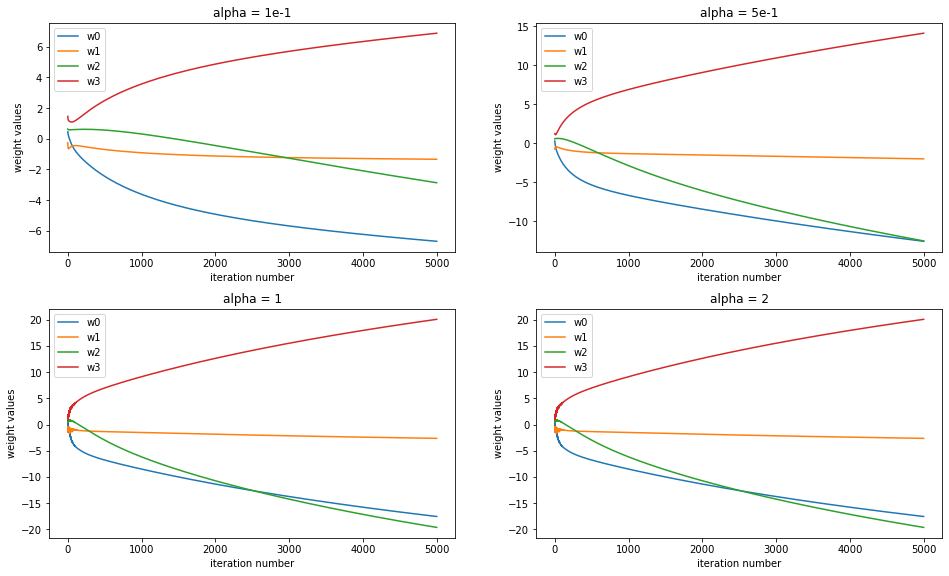

In [33]:
plt.figure(figsize=(16, 20))

plt.subplot(421)
plt.plot(range(len(w_log0)), w_log0)
plt.xlabel('iteration number')
plt.ylabel('weight values')
plt.title('alpha = 1e-1')
plt.legend(['w0', 'w1', 'w2', 'w3'])

plt.subplot(422)
plt.plot(range(len(w_log)), w_log)
plt.xlabel('iteration number')
plt.ylabel('weight values')
plt.title('alpha = 5e-1')
plt.legend(['w0', 'w1', 'w2', 'w3'])

plt.subplot(423)
plt.plot(range(len(w_log1)), w_log1)
plt.xlabel('iteration number')
plt.ylabel('weight values')
plt.title('alpha = 1')
plt.legend(['w0', 'w1', 'w2', 'w3'])

plt.subplot(424)
plt.plot(range(len(w_log2)), w_log1)
plt.xlabel('iteration number')
plt.ylabel('weight values')
plt.title('alpha = 2')
plt.legend(['w0', 'w1', 'w2', 'w3'])

plt.subplots_adjust(hspace=1/4)
plt.show

Можно увидеть, как с увеличение альфа растут веса, практически не выходя на плато (обратите внимание на значения по оси ординат)

### Задание 7. Создайте функции eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций соответственно.

In [34]:
# алгоритм логистической регрессии с L2-регуляризацией
def eval_model_l2(X, y, iterations, alpha=1e-4, metric: callable = None, lambda_ = 0):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    
    metric_log = []
    w_log = []
    
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = metric(y, y_pred)
        
        W -= alpha * (1/n * np.dot((y_pred - y), X.T) + 2 * lambda_ * W)
        metric_log.append(err)
        w_log.append(W.copy())
        
        if i % (iterations / 10) == 0:
            print(i, W, err)
        
    return W, metric_log, w_log

In [135]:
# алгоритм логистической регрессии с L1-регуляризацией
def eval_model_l1(X, y, iterations, alpha=1e-4, metric: callable = None, lambda_ = 0):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    
    metric_log = []
    w_log = []
    
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = metric(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T) +  lambda_ * np.sign(W))
        metric_log.append(err)
        w_log.append(W.copy())
        
        if i % (iterations / 10) == 0:
            print(i, W, err)
        
    return W, metric_log, w_log

### Анализ модели логистической регрессии с L2-регуляризацией

In [113]:
W_l2, metric_log_l2_3, w_log_l2 = eval_model_l2(X_norm, y, 5000, alpha=5e-1, metric=calc_logloss, lambda_=1e-2)

500 [-1.7953356  -0.51495646  0.04966846  1.93587845] 0.4788271475189611
1000 [-1.79610227 -0.51486082  0.04658059  1.93680383] 0.4787668255813304
1500 [-1.79610407 -0.51486036  0.04657034  1.93680625] 0.47876667994094857
2000 [-1.79610407 -0.51486035  0.04657031  1.93680626] 0.47876667947784046
2500 [-1.79610407 -0.51486035  0.04657031  1.93680626] 0.4787666794763412
3000 [-1.79610407 -0.51486035  0.04657031  1.93680626] 0.47876667947633644
3500 [-1.79610407 -0.51486035  0.04657031  1.93680626] 0.47876667947633644
4000 [-1.79610407 -0.51486035  0.04657031  1.93680626] 0.47876667947633644
4500 [-1.79610407 -0.51486035  0.04657031  1.93680626] 0.47876667947633644
5000 [-1.79610407 -0.51486035  0.04657031  1.93680626] 0.47876667947633644


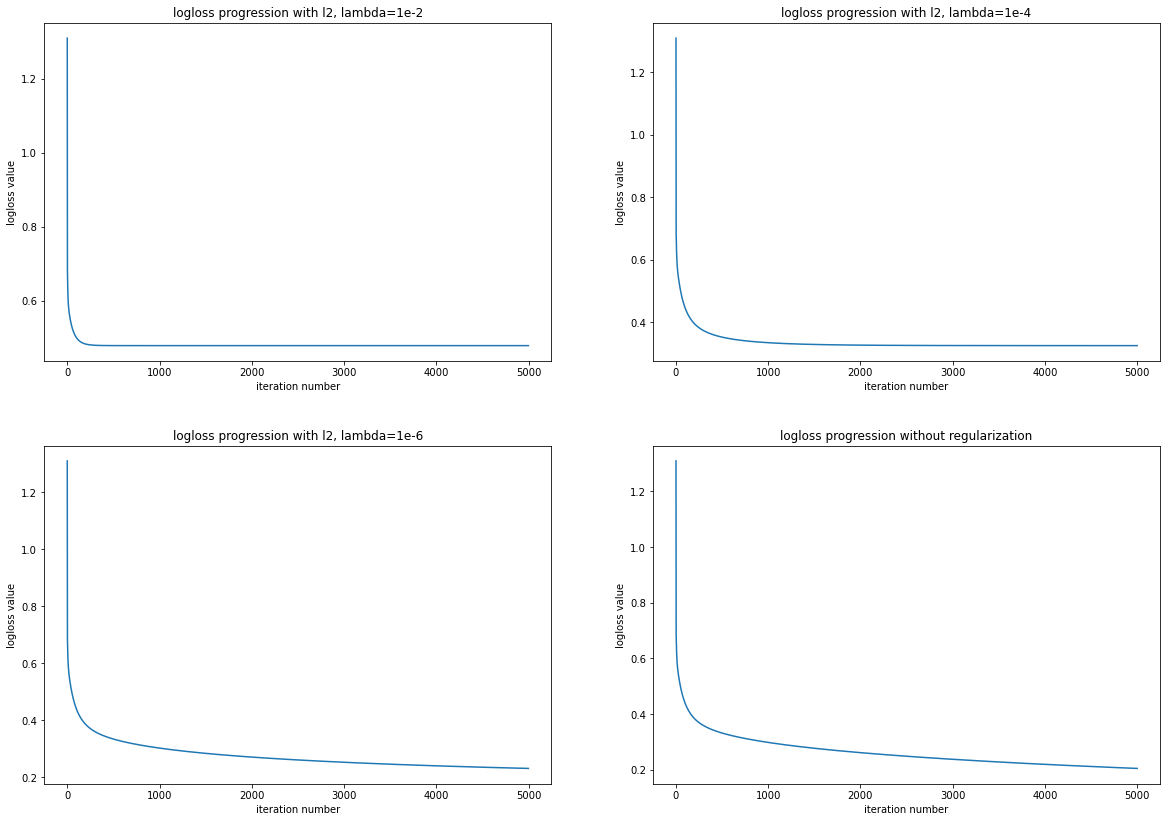

In [110]:
fig = plt.figure(figsize=(20, 14))

plt.subplot(221)
plt.plot(range(len(metric_log_l2_1)), metric_log_l2_1)
plt.title('logloss progression with l2, lambda=1e-2')
plt.xlabel('iteration number')
plt.ylabel('logloss value')

plt.subplot(222)
plt.plot(range(len(metric_log_l2_2)), metric_log_l2_2)
plt.title('logloss progression with l2, lambda=1e-3')
plt.xlabel('iteration number')
plt.ylabel('logloss value')

plt.subplot(223)
plt.plot(range(len(metric_log_l2_3)), metric_log_l2_3)
plt.title('logloss progression with l2, lambda=1e-4')
plt.xlabel('iteration number')
plt.ylabel('logloss value')

plt.subplot(224)
plt.plot(range(len(metric_log)), metric_log)
plt.title('logloss progression without regularization')
plt.xlabel('iteration number')
plt.ylabel('logloss value')

plt.subplots_adjust(hspace=1/4)
plt.show()

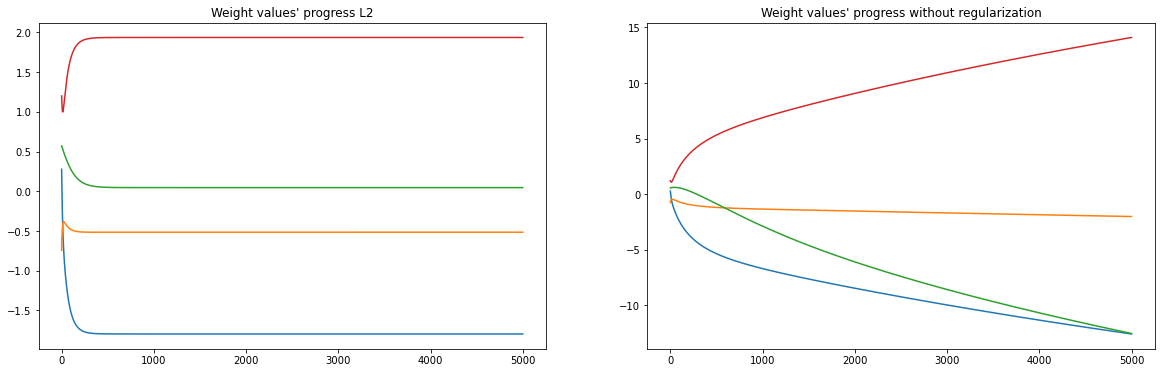

In [157]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.plot(range(len(w_log_l2)), w_log_l2)
plt.title("Weight values' progress L2")

plt.subplot(122)
plt.plot(range(len(w_log)), w_log)
plt.title("Weight values' progress without regularization")

plt.show()

По графикам видно, что регуляризация затрудняет увеличение весов для модели  
  
Как следствие, упали финальные значения logloss  
  
Но как я предполагаю, контролируя лямбду (коэфф. регуляризации) можно контролировать актуальность модели на будущих, тестовых данных  
  
Другими словами, регуляризация контролирует процесс переобучение модели

### Анализ модели логистической регрессии с L1-регуляризацией

In [152]:
W_l1, metric_log_l1_2, w_log_l1 = eval_model_l1(X_norm, y, 5000, alpha=5e-1, metric=calc_logloss, lambda_ = 1e-2)

500 [-4.11424112e+00 -9.71985325e-01  1.02426141e-03  4.03907925e+00] 0.3664321276452635
1000 [-4.54592455 -1.06027336 -0.00584432  4.44657105] 0.35526884405389636
1500 [-4.62520896e+00 -1.07699876e+00 -2.79056725e-03  4.52179365e+00] 0.3535196196955498
2000 [-4.64065064 -1.07976706 -0.00765801  4.53679794] 0.35313965979596307
2500 [-4.64373239 -1.08036447 -0.00808041  4.53974913] 0.35306916921866954
3000 [-4.64454242e+00 -1.08127209e+00  3.36422058e-04  4.53996462e+00] 0.35312720185569896
3500 [-4.64462370e+00 -1.08115476e+00 -1.32760856e-03  4.54017875e+00] 0.35311009038541546
4000 [-4.64460285e+00 -1.08100994e+00 -3.04247222e-03  4.54029488e+00] 0.35309480075324157
4500 [-4.64456668 -1.08085    -0.00478197  4.54037626] 0.35307995066954445
5000 [-4.64452725 -1.08068312 -0.00653505  4.54044411] 0.3530652248943392


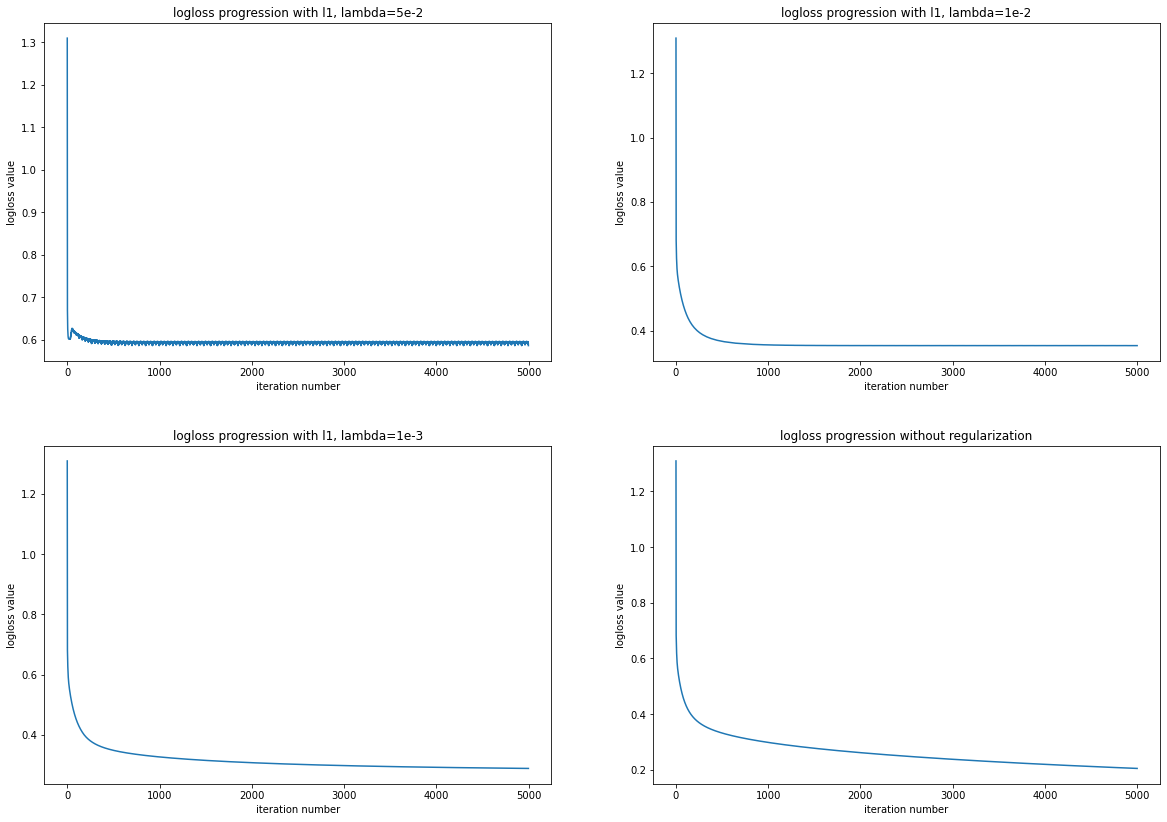

In [149]:
fig = plt.figure(figsize=(20, 14))

plt.subplot(221)
plt.plot(range(len(metric_log_l1_1)), metric_log_l1_1)
plt.title('logloss progression with l1, lambda=5e-2')
plt.xlabel('iteration number')
plt.ylabel('logloss value')

plt.subplot(222)
plt.plot(range(len(metric_log_l1_2)), metric_log_l1_2)
plt.title('logloss progression with l1, lambda=1e-2')
plt.xlabel('iteration number')
plt.ylabel('logloss value')

plt.subplot(223)
plt.plot(range(len(metric_log_l1_3)), metric_log_l1_3)
plt.title('logloss progression with l1, lambda=1e-3')
plt.xlabel('iteration number')
plt.ylabel('logloss value')

plt.subplot(224)
plt.plot(range(len(metric_log)), metric_log)
plt.title('logloss progression without regularization')
plt.xlabel('iteration number')
plt.ylabel('logloss value')

plt.subplots_adjust(hspace=1/4)
plt.show()

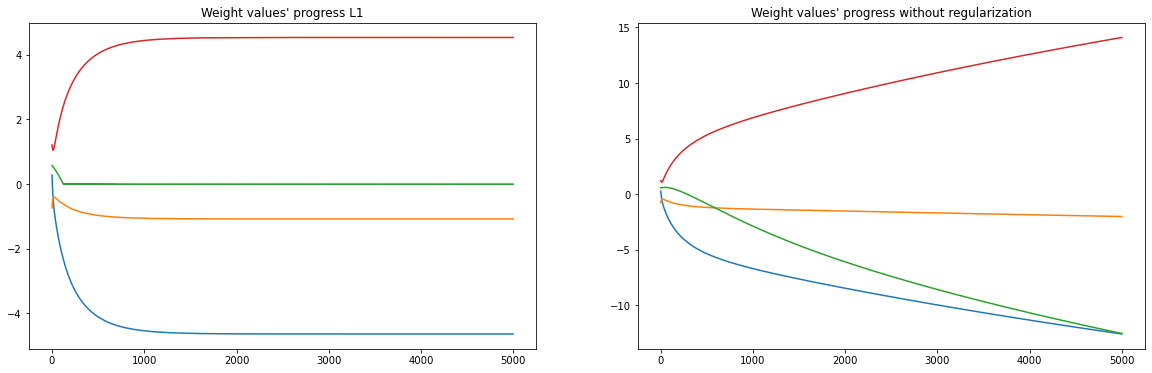

In [156]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.plot(range(len(w_log_l1)), w_log_l1)
plt.title("Weight values' progress L1")

plt.subplot(122)
plt.plot(range(len(w_log)), w_log)
plt.title("Weight values' progress without regularization")

plt.show()

Видим ту же историю, что и с L2-регуляризацией  
  
Модель штрафуется за большие веса, поэтому значения весов быстро упираются в свой предел  
  
Со значениями logloss происходит тоже самое, чем больше значение лямбды - тем быстрее модель упрется в предел